## Lab 5 - Dyfuzja
Błażej Nowicki

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import random
import math

Definiujemy domyślne parametry

In [2]:
T = 1000
beta_1 = 0.0001
beta_t = 0.02

betas = torch.linspace(beta_1, beta_t, T)
alpha = 1 - betas
alpha_dash = torch.clone(alpha)

for i in range(1, T):
    alpha_dash[i] = alpha_dash[i - 1] * alpha[i]

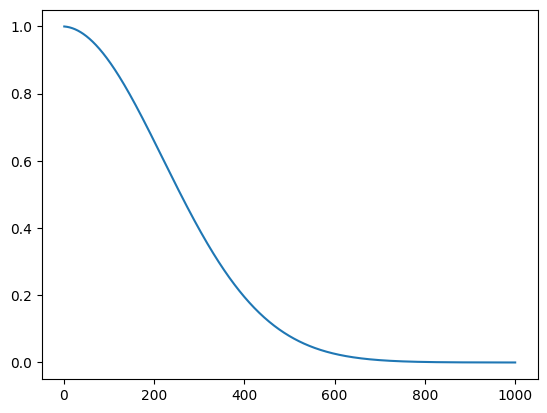

In [3]:
plt.plot(list(range(1, T + 1)), alpha_dash)

Wyternowałem model na powyższych wartościach i dawały dobre rezultaty ale model miał problem z ostatecznym wyostrzeniem. Jednym z wytłumaczeń które przyszły mi do głowy było za mało kroków treningowych na mało zaszumionych obrazach. W poprawionej wersji dostosowałem wartości skrajne beta tak żeby spadek był bardziej równomierny. 

In [4]:
T = 1000
beta_1 = 0.00001
beta_t = 0.005

betas = torch.linspace(beta_1, beta_t, T)
alpha = 1 - betas
alpha_dash = torch.clone(alpha)

for i in range(1, T):
    alpha_dash[i] = alpha_dash[i - 1] * alpha[i]

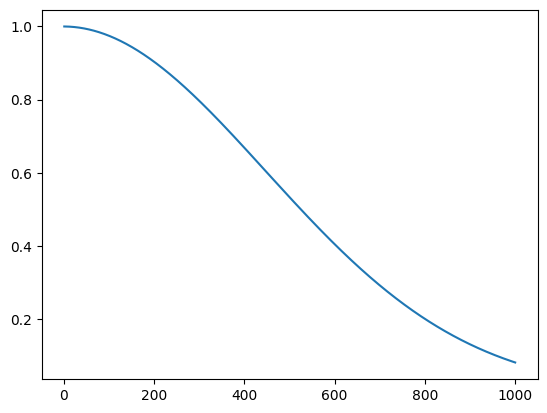

In [5]:
plt.plot(list(range(1, T + 1)), alpha_dash)

Wczytujemy dane treningowe z pliku

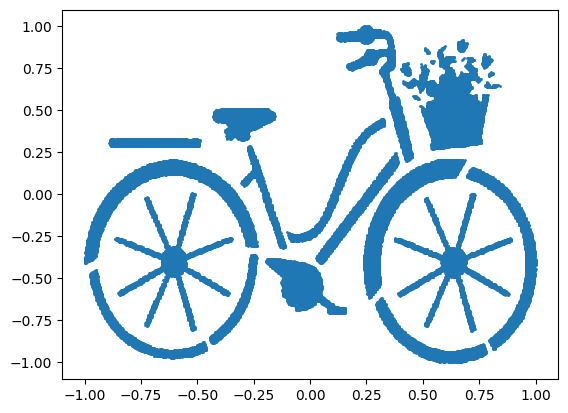

In [6]:
class BicycleDataset(Dataset):
    def __init__(self):
        with open("bicycle.txt") as file:
            lines = file.readlines()

        raw_points = [list(map(float, line.split())) for line in lines]
        self.data = [torch.tensor(point) for point in raw_points]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


dataset = BicycleDataset()
loader = DataLoader(dataset, batch_size=len(dataset))
points = next(iter(loader))
plt.scatter(points[:, 0], points[:, 1], s=1)

Testujemy dodawanie szumu

In [7]:
def add_noise(points, noise, t):
    a_t = alpha_dash[t]
    return torch.sqrt(a_t) * points + torch.sqrt(torch.tensor(1) - a_t) * noise

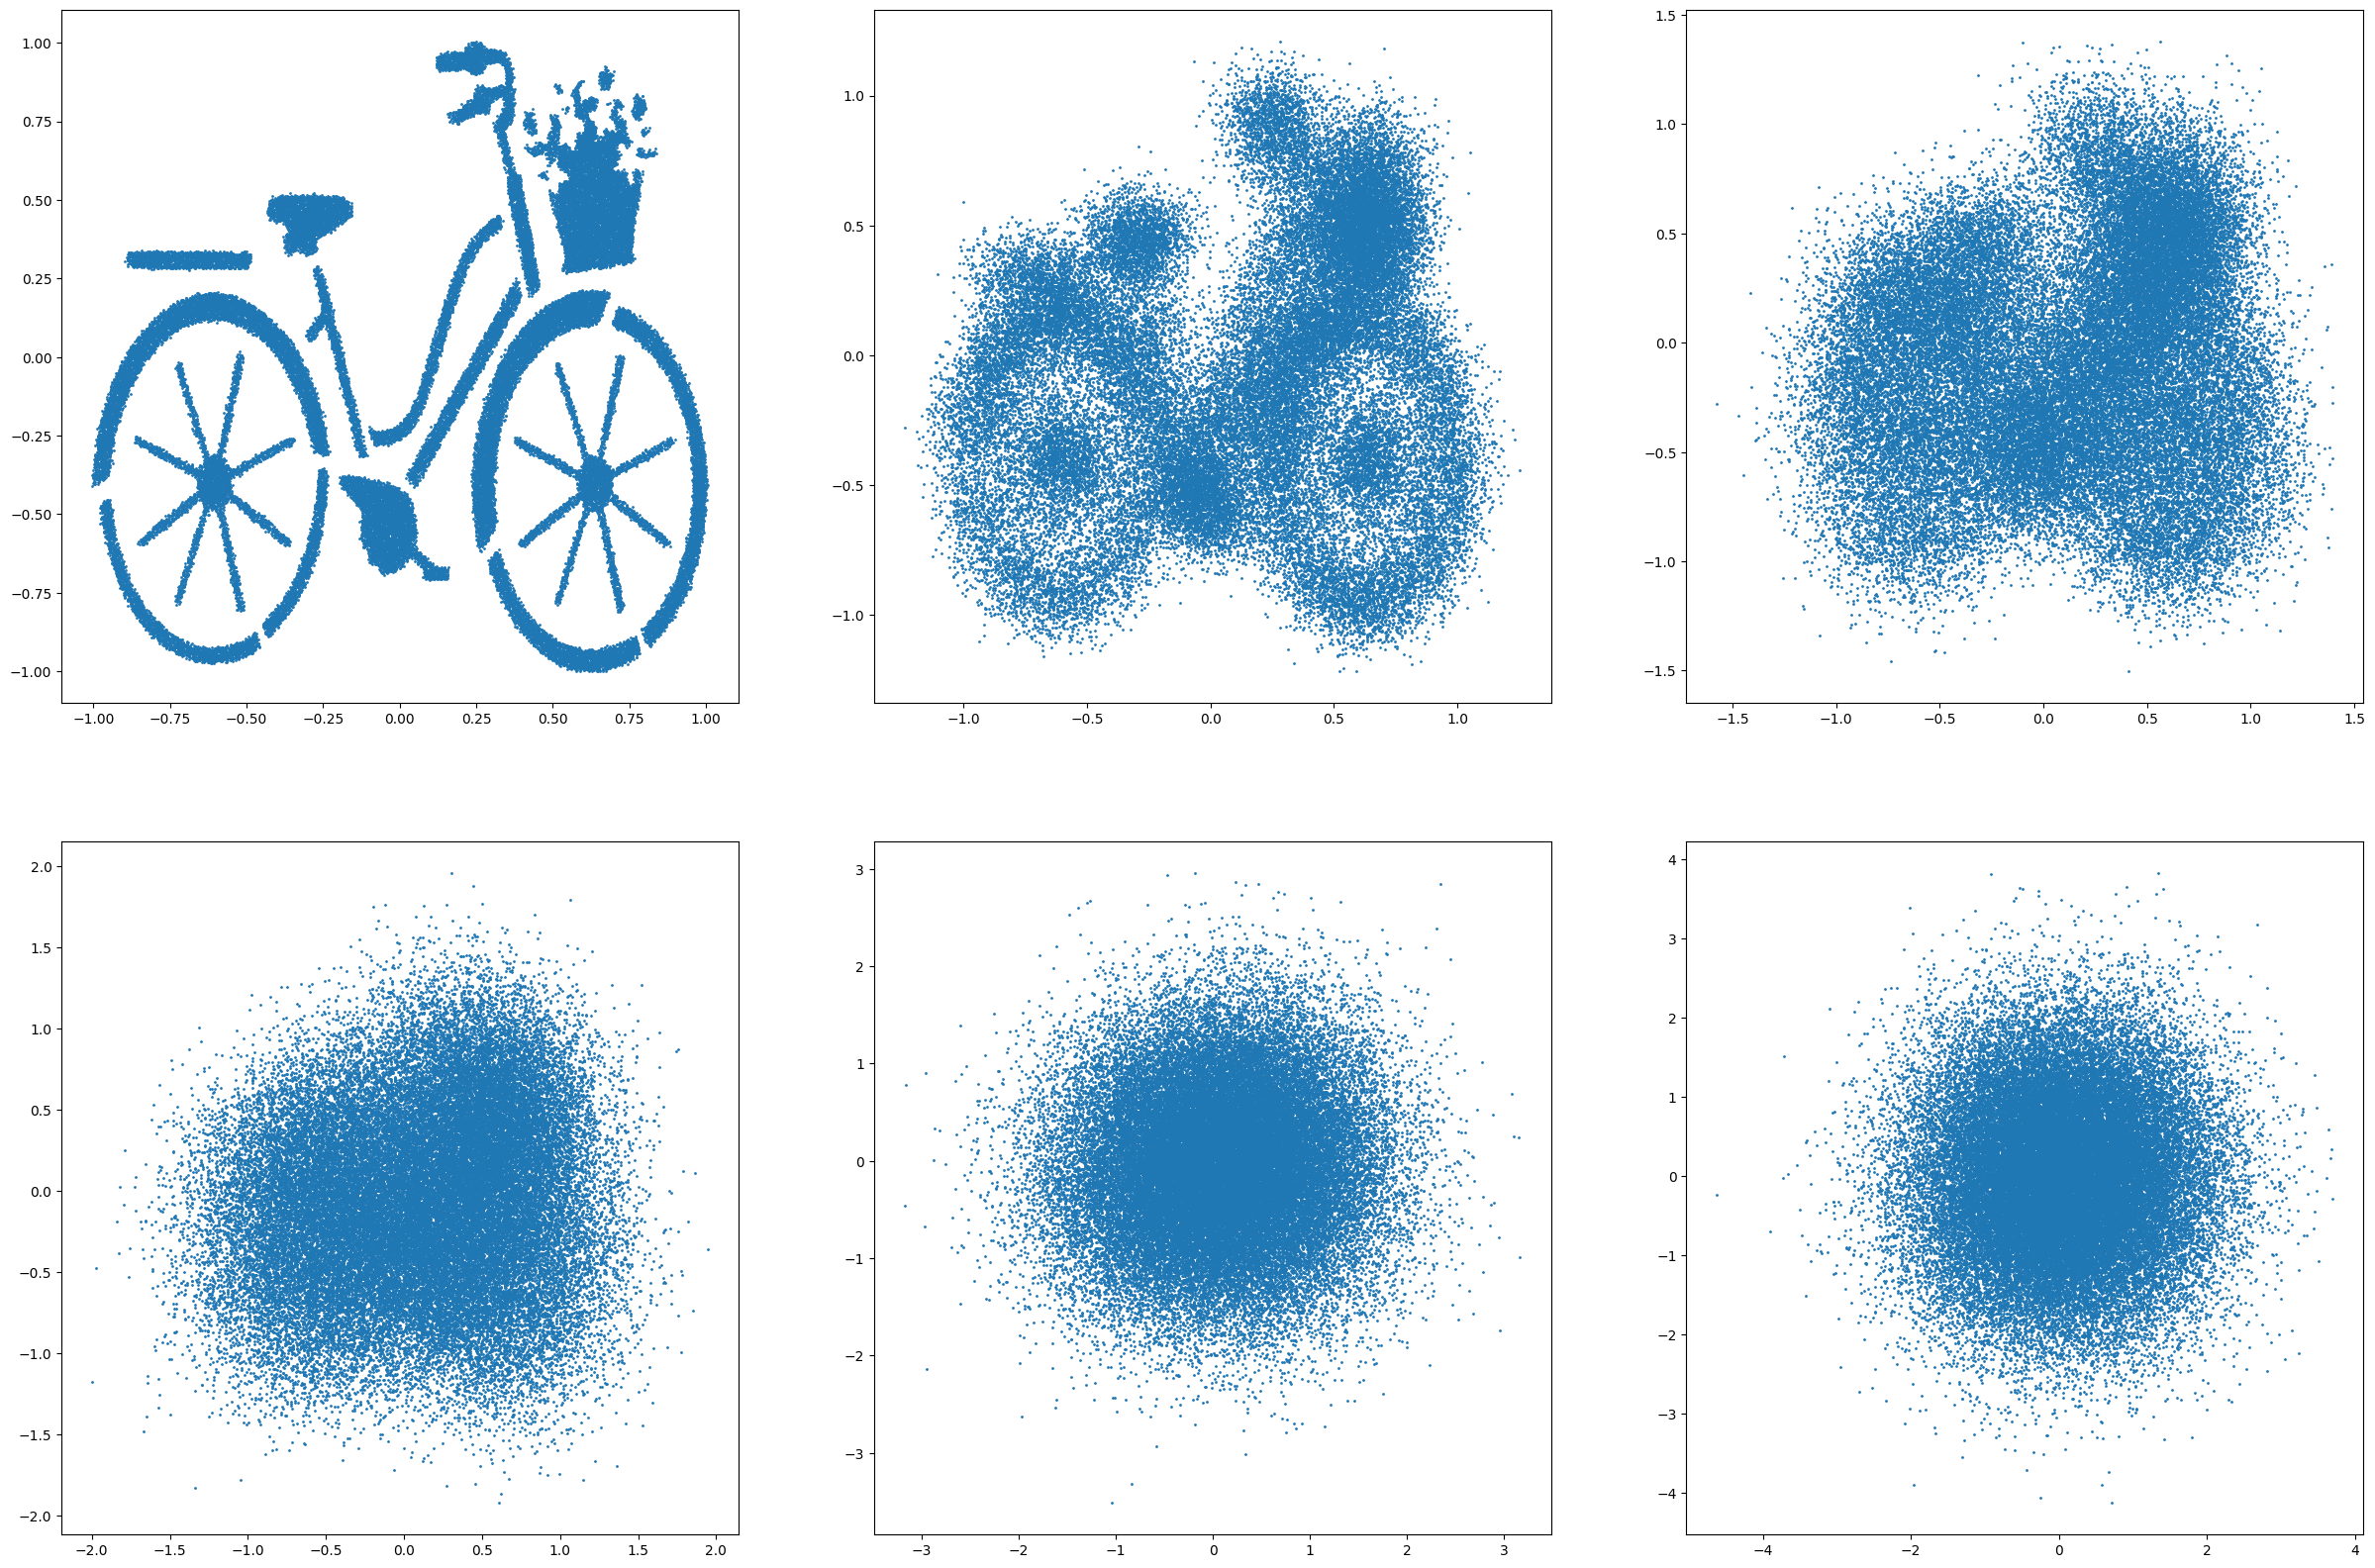

In [8]:
fix, axs = plt.subplots(2, 3, figsize=(30, 20))
for i, t in enumerate([0, 50, 100, 200, 500, 999]):
    data = torch.clone(points)
    noise = torch.randn(data.shape)
    data = add_noise(points, noise, t)
    axs[i // 3, i % 3].scatter(data[:, 0], data[:, 1], s=1)

"Czysty" szum dla porównania

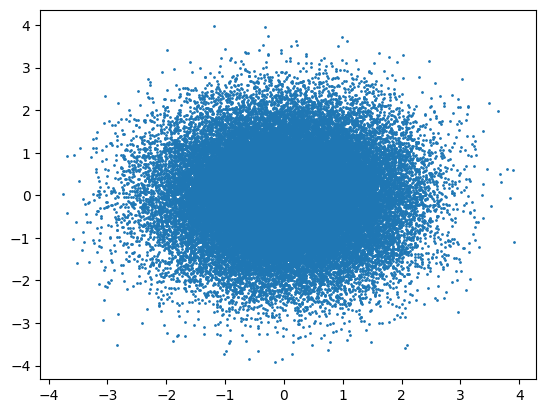

In [9]:
perfect_normal = torch.randn(points.shape)
plt.scatter(perfect_normal[:, 0], perfect_normal[:, 1], s=1)

Kodowanie pozycji

In [10]:
# Modified from: https://gist.github.com/danimelchor/f99083a259172c37bd7098a12c2b0574


class PositionalEncoding(nn.Module):
    def __init__(self, dim_model, max_len):
        super().__init__()
        # Encoding - From formula
        pos_encoding = torch.zeros(max_len, dim_model)
        positions_list = torch.arange(0, max_len, dtype=torch.float).view(
            -1, 1
        )  # 0, 1, 2, 3, 4, 5
        division_term = torch.exp(
            torch.arange(0, dim_model, 2).float() * (-math.log(10000.0)) / dim_model
        )  # 1000^(2i/dim_model)

        # PE(pos, 2i) = sin(pos/1000^(2i/dim_model))
        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)

        # PE(pos, 2i + 1) = cos(pos/1000^(2i/dim_model))
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)

        # Saving buffer (same as parameter without gradients needed)
        pos_encoding = pos_encoding
        self.register_buffer("pos_encoding", pos_encoding)

    def forward(self, t) -> torch.tensor:
        return self.pos_encoding[t]


p = PositionalEncoding(4, 5)
print(p(0))
p.pos_encoding

tensor([0., 1., 0., 1.])


tensor([[ 0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0100,  0.9999],
        [ 0.9093, -0.4161,  0.0200,  0.9998],
        [ 0.1411, -0.9900,  0.0300,  0.9996],
        [-0.7568, -0.6536,  0.0400,  0.9992]])

Definiujemy model zgodnie z poleceniem

In [11]:
class LearnableSinusoidalEmbedding(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.net = nn.Sequential(
            PositionalEncoding(dim_model=50, max_len=T),
            nn.Linear(50, 128),
            nn.ReLU(),
            nn.Linear(128, output_size),
        )

    def forward(self, t):
        return self.net(t)


class ConditionalDenseLayer(nn.Module):
    def __init__(
        self, input_size: int, output_size: int, skip_activation: bool = False
    ):
        super().__init__()
        self.x_net = nn.Linear(input_size, output_size)
        self.t_net = LearnableSinusoidalEmbedding(output_size)
        self.relu = nn.ReLU() if not skip_activation else nn.Identity()

    def forward(self, x, t):
        x = torch.add(self.x_net(x), self.t_net(t))
        x = self.relu(x)

        return x


class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList(
            [
                ConditionalDenseLayer(2, 128),
                ConditionalDenseLayer(128, 128),
                ConditionalDenseLayer(128, 128),
                ConditionalDenseLayer(128, 2, skip_activation=True),
            ]
        )

    def forward(self, x, t):
        for layer in self.layers:
            x = layer(x, t)

        return x


x = torch.randn((5, 2))
t = torch.randint(0, T, (5,))
m = Model()
y = m(x, t)
print(y.shape)
y

torch.Size([5, 2])


tensor([[ 0.1823, -0.0667],
        [ 0.1836,  0.0101],
        [ 0.3228,  0.0362],
        [ 0.3584, -0.1488],
        [ 0.0534,  0.0315]], grad_fn=<AddBackward0>)

Dodawanie szumu jeszcze raz. Tym razem `t` będzie wektorem o wymiarach (batch_size,1)

In [12]:
def add_noise(points, noise, t):
    a_t = alpha_dash[t]
    return (
        torch.sqrt(a_t).unsqueeze(1) * points + torch.sqrt(1 - a_t).unsqueeze(1) * noise
    )

Trenujemy model

In [19]:
start_epoch = 210
last_epoch = 600
batch_size = 64
criterion = nn.L1Loss()
checkpoint_path = lambda epoch: f"checkpoints/{epoch}.pt"

dataset = BicycleDataset()
data_loader = DataLoader(dataset, batch_size, drop_last=True, shuffle=True)

model = Model()
optimizer = torch.optim.Adam(model.parameters(), 0.0001)

if start_epoch > 0:
    checkpoint = torch.load(checkpoint_path(start_epoch-1))
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])


for epoch in range(start_epoch, last_epoch):
    epoch_loss = []

    for x in data_loader:
        noise = torch.randn((batch_size, 2))
        t = torch.randint(0, T, (batch_size,))

        optimizer.zero_grad()
        loss = criterion(noise, model(add_noise(x, noise, t), t))
        loss.backward()
        optimizer.step()

        epoch_loss.append(float(loss))

    if (epoch+1) % 5 == 0:
        print(f"Epoch: {epoch+1} loss: {sum(epoch_loss) / len(epoch_loss)}")

    if (epoch+1) % 10 == 0:
        torch.save({
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
        }, checkpoint_path(epoch))


Epoch: 215 loss: 0.41296715115381377
Epoch: 220 loss: 0.4136681479170238
Epoch: 225 loss: 0.4159183428447864
Epoch: 230 loss: 0.41431851076141835
Epoch: 235 loss: 0.4133498907694357
Epoch: 240 loss: 0.4140069479794067
Epoch: 245 loss: 0.41400924366591546
Epoch: 250 loss: 0.41248598592686775
Epoch: 255 loss: 0.4141136321243901
Epoch: 260 loss: 0.4135971490653033
Epoch: 265 loss: 0.4132955634049353
Epoch: 270 loss: 0.4138464767315666
Epoch: 275 loss: 0.41110897990804035
Epoch: 280 loss: 0.41246907012111644
Epoch: 285 loss: 0.414480758651259
Epoch: 290 loss: 0.41563233729395166
Epoch: 295 loss: 0.41442478833918645
Epoch: 300 loss: 0.41546732160796973
Epoch: 305 loss: 0.41448105172003585
Epoch: 310 loss: 0.4176928492896448
Epoch: 315 loss: 0.4121653253051835
Epoch: 320 loss: 0.41465334711492363
Epoch: 325 loss: 0.4156152010342191
Epoch: 330 loss: 0.4169439173062441
Epoch: 335 loss: 0.41392066647407366
Epoch: 340 loss: 0.4134606457679405
Epoch: 345 loss: 0.411050590955969
Epoch: 350 loss: 0

Całe szkolenie trwało 600 iteracji przez wszystkie punkty. Loss prawie od razu spada do 0.43 i nie poprawia się poniżej 0.41. Podczas kiedy wizualnie jakość efetków znacznie się poprawia. Różnica jest głównie w wykończeniu.

Generujemy nowe punkty z czystego szumu

In [20]:
def generate_points(model, samples):
    with torch.no_grad():
        x = torch.randn((samples, 2))
        for t in range(T - 1, -1, -1):
            z = torch.randn((samples, 2)) if t > 0 else torch.zeros((samples, 2))
            x = (
                1
                / alpha[t] ** 0.5
                * (x - (1 - alpha[t]) / (1 - alpha_dash[t]) ** 0.5 * model(x, t))
                + betas[t] ** 0.5 * z
            )
    return x

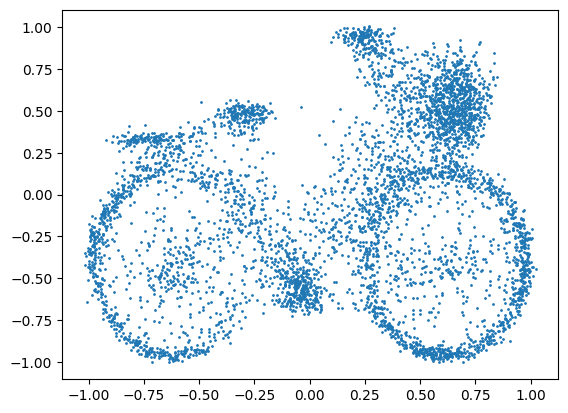

In [21]:
x =  generate_points(model, 5000)
plt.scatter(x[:, 0], x[:, 1], s=1)

Nice

I na koniec wizualizacja postępów w uczeniu

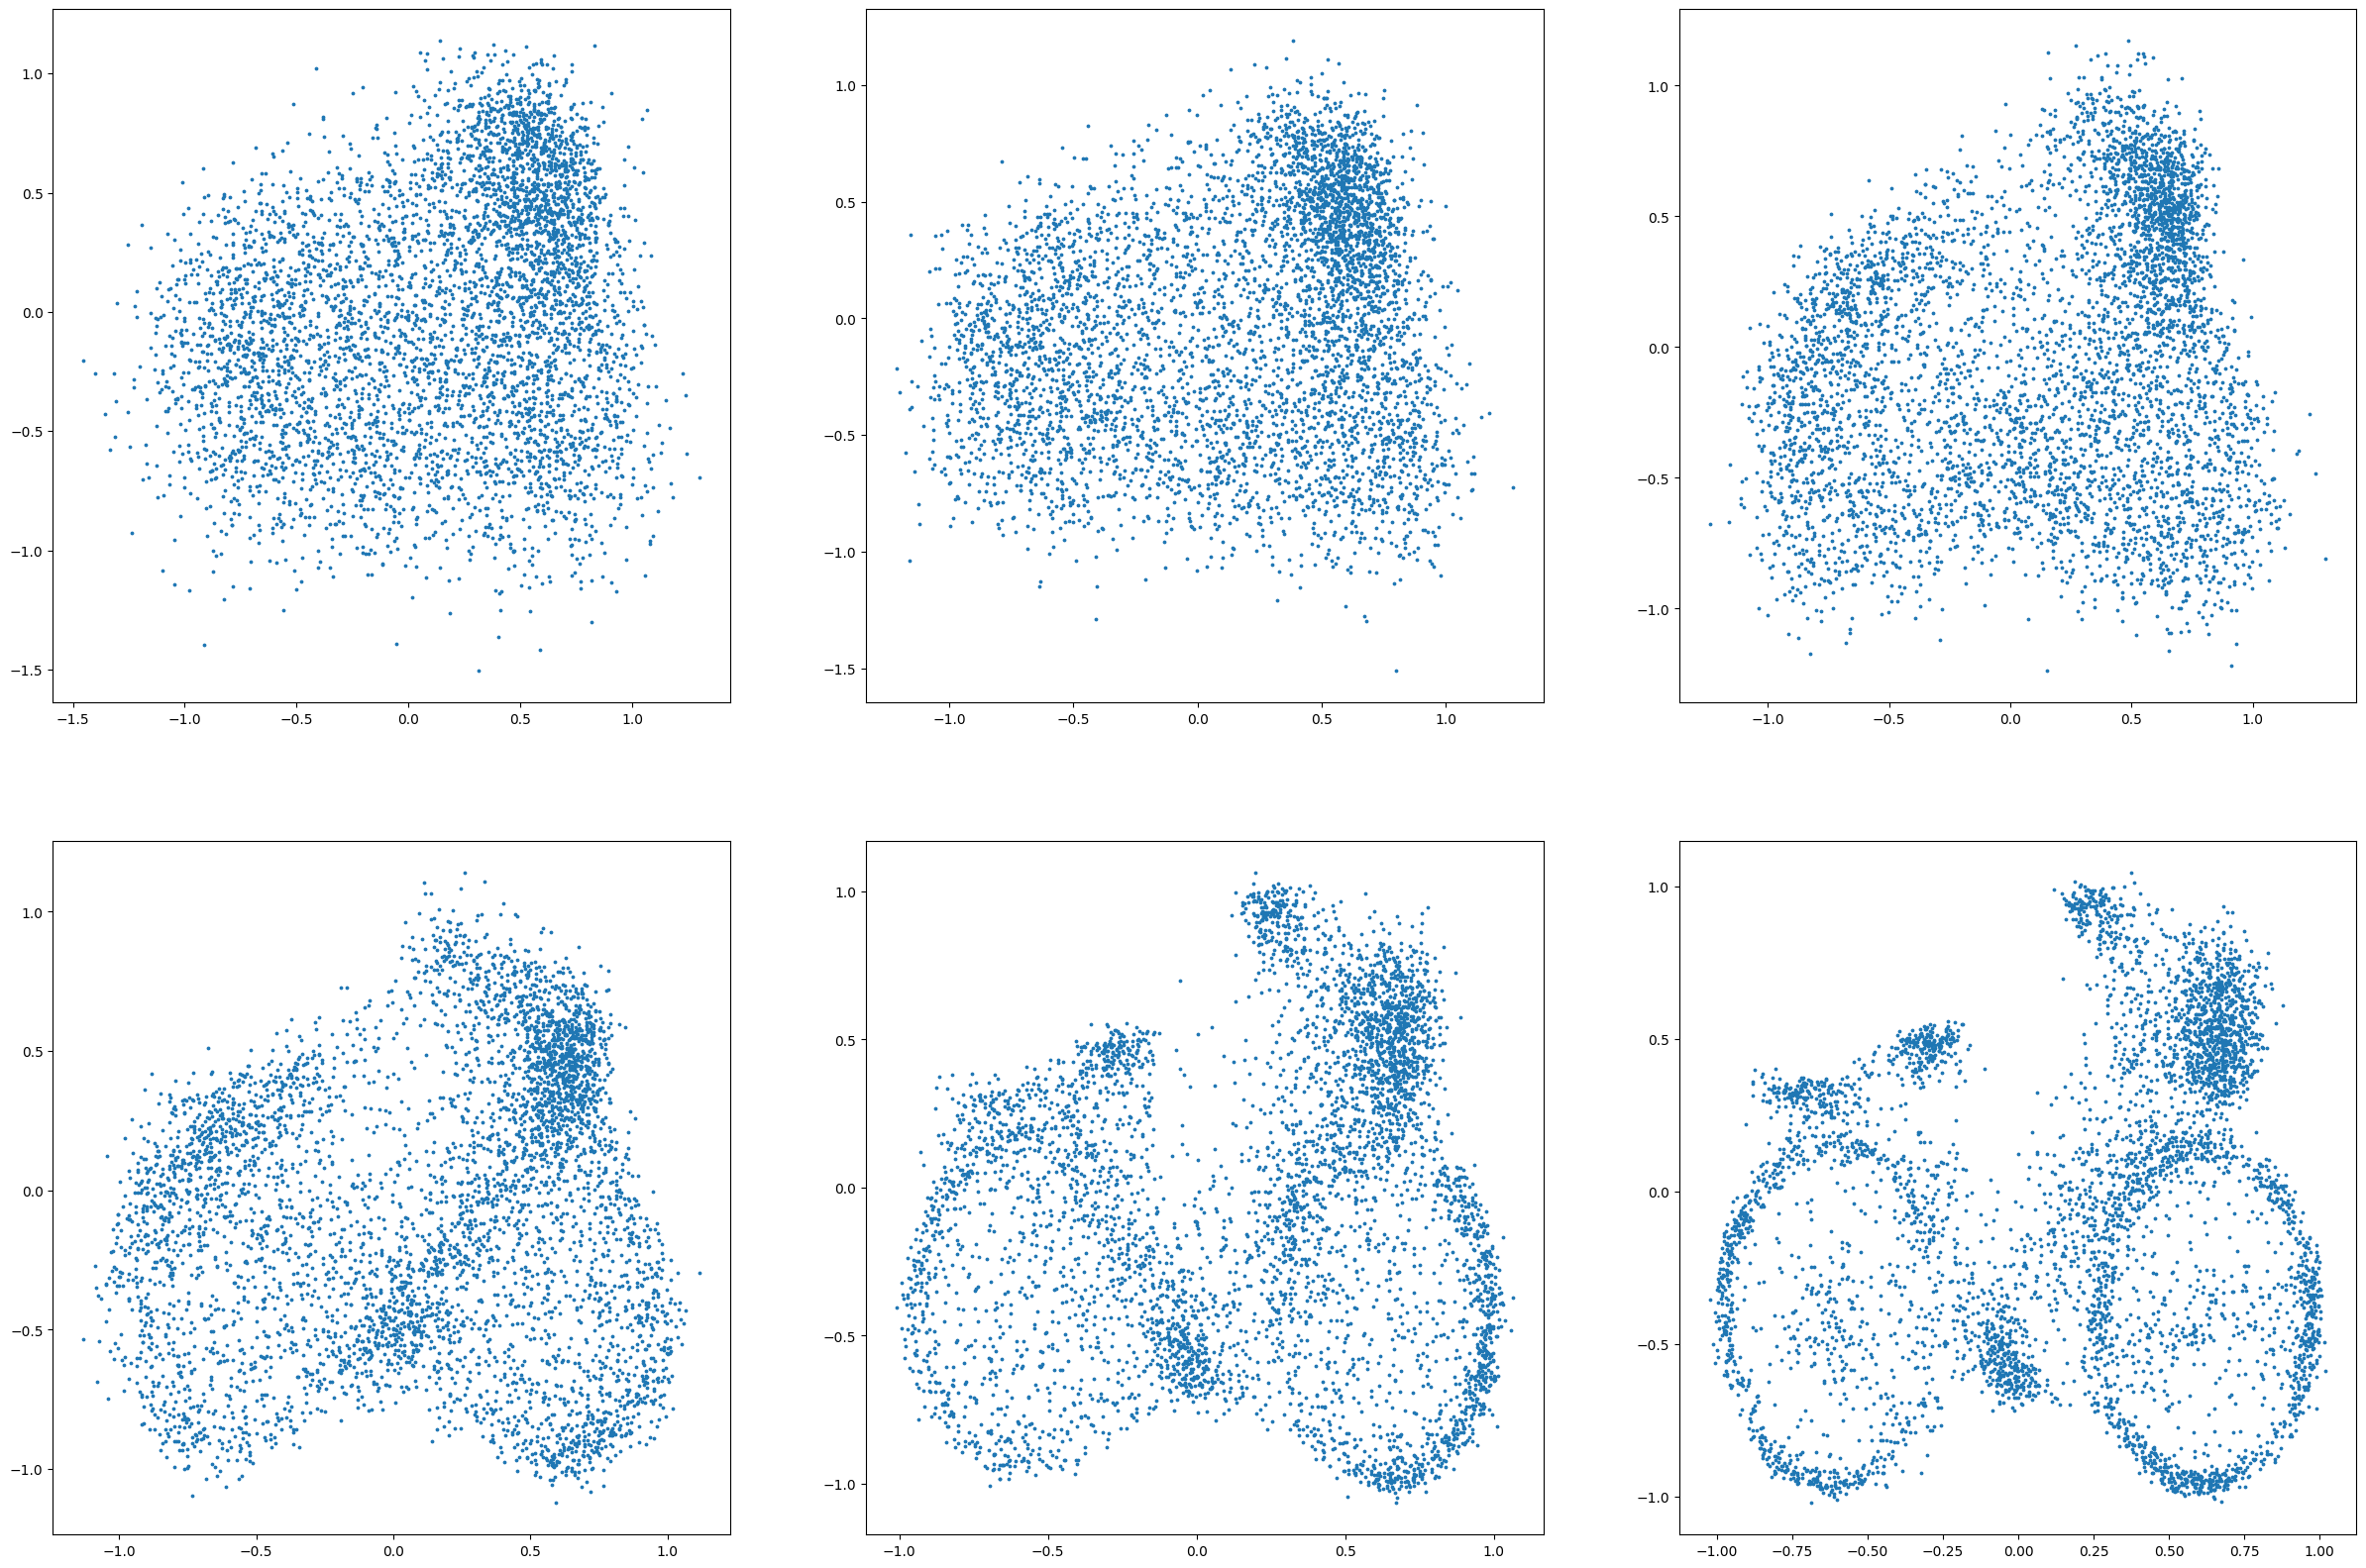

In [22]:
fix, axs = plt.subplots(2, 3, figsize=(30, 20))
for i, epoch in enumerate([10, 20, 50, 100, 300, 600]):
    checkpoint = torch.load(checkpoint_path(epoch-1))
    model = Model()
    model.load_state_dict(checkpoint["model"])
    x = generate_points(model, 5000)
    axs[i // 3, i % 3].scatter(x[:, 0], x[:, 1], s=3)